In [1]:
#Bibliotecas
import numpy as np
from matplotlib import pylab
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
SEED = 42

In [2]:
#Cargar el dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
#Particiones del dataset
#Primera división: Entrenamiento y Test (80% train y 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
# Segunda división: dentro del conjunto de entrenamiento, separar Validación (20% de lo inicial)
# 0.25 * 0.8 = 0.2, por lo que el 20% total es usado para validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED, stratify=y_train)

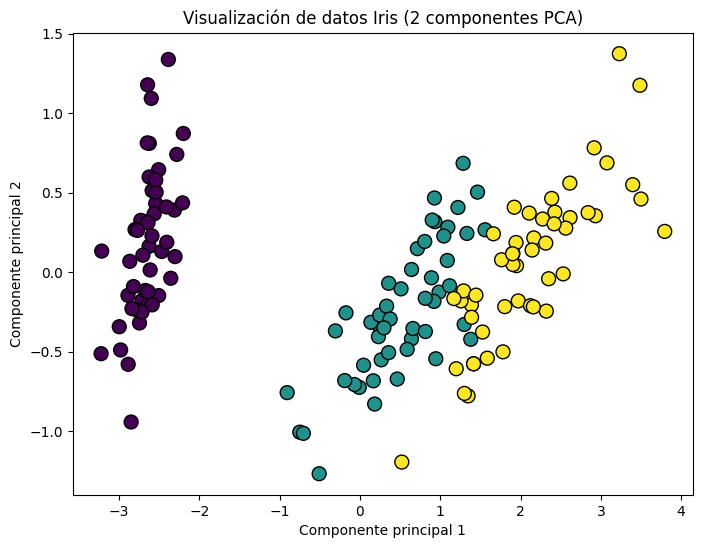

In [4]:
#Visualización de datos
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X)

fig = pylab.figure(1, figsize=(8, 6))
pylab.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=100)
pylab.title('Visualización de datos Iris (2 componentes PCA)')
pylab.xlabel('Componente principal 1')
pylab.ylabel('Componente principal 2')
pylab.show()

In [5]:
#Ajuste de hiperparámetros
train_indices = np.full(X_train.shape[0], -1)  # Los datos de entrenamiento son indicados con -1
val_indices = np.full(X_val.shape[0], 0)  # Los datos de validación son indicados con 0
test_fold = np.concatenate([train_indices, val_indices])

X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

ps = PredefinedSplit(test_fold=test_fold)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=ps, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_val, y_train_val)

print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
Mejores hiperparámetros encontrados: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [6]:
#Entrenar el mejor modelo con los hiperparámetros optimizados
best_rf = grid_search.best_estimator_
best_rf.random_state = SEED
best_rf.fit(X_train, y_train)  # Entrenar solo con el conjunto de entrenamiento original

RandomForestClassifier(n_estimators=50, random_state=42)

Exactitud en el conjunto de test: 0.93


<Figure size 800x600 with 0 Axes>

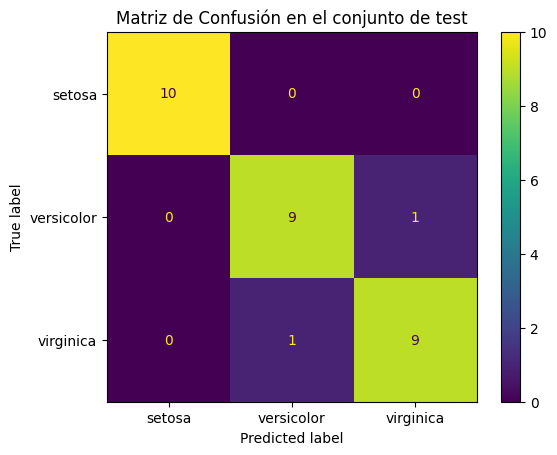

In [7]:
#Evaluar el modelo en el conjunto de test
test_predictions = best_rf.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Exactitud en el conjunto de test: {test_accuracy:.2f}")

cm = confusion_matrix(y_test, test_predictions, labels=best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)

fig = pylab.figure(2, figsize=(8, 6))
disp.plot()
pylab.title('Matriz de Confusión en el conjunto de test')
pylab.show()